In [1]:
# import python packages
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import pickle
import os
import importlib
from scipy.stats import chi2_contingency
from statsmodels.stats.multitest import multipletests
import matplotlib.pyplot as plt
import itertools
from scipy import stats

In [2]:
site_list = ['KUMC', 'UTSW', 'MCW', 'UofU', 'UIOWA', 'UMHC', 'UPITT', 'MCRI', 'UTHSCSA', 'UNMC']
ext_list = ['csv','dsv', 'dsv', 'csv', 'csv', 'csv', 'csv', 'csv', 'csv']
sep_list = [',','|', '|', '|', ',', ',', ',', ',', '|']
encoding_list = ['utf-8','utf-8','utf-8','utf-8','utf-8','utf-8', 'windows-1252', 'utf-8','utf-16'] 
ct = 0

daily_average = True


site = site_list[ct]
ext = ext_list[ct]
sep = sep_list[ct]
encoding = encoding_list[ct]
path = []

if site != 'KUMC':
    rawpath = '/blue/yonghui.wu/hoyinchan/Data/data2022raw/' + site + '/raw/'
else: 
    rawpath = '/blue/yonghui.wu/hoyinchan/Data/data2022raw/' + site + '_ORCALE/raw/'
path.append(rawpath)
path.append('/blue/yonghui.wu/hoyinchan/Data/data2022/' + site + '/')
pdata = '/blue/yonghui.wu/hoyinchan/Data/data2022/'+ site 
site

'KUMC'

# Comment on Baseline Def

In [71]:
df_counts = list()
for site in site_list:
    print(site)
    df_base = pd.read_pickle(pdata+'/df_base00.pkl')
    df_base = df_base.drop(['SPECIMEN_DATE', 'RESULT_NUM'],axis=1)
    df_base = df_base.drop_duplicates()
    df_count = df_base.copy()
    df_count['ONE_WEEK_SCR'] = df_count['ONE_WEEK_SCR'] == df_count['SERUM_CREAT_BASE']
    df_count['ADMISSION_SCR'] = (df_count['ADMISSION_SCR'] == df_count['SERUM_CREAT_BASE']) & ~df_count['ONE_WEEK_SCR']
    df_count['ONE_YEAR_SCR'] = (df_count['ONE_YEAR_SCR'] == df_count['SERUM_CREAT_BASE'])  & ~df_count['ONE_WEEK_SCR']
    df_count['BASELINE_NO_MDRD'] = (df_count['BASELINE_NO_MDRD'] == df_count['SERUM_CREAT_BASE']) & ~df_count['ONE_WEEK_SCR'] & ~df_count['ONE_YEAR_SCR']
    df_count = df_count[['ADMISSION_SCR', 'ONE_WEEK_SCR', 'ONE_YEAR_SCR', 'BASELINE_NO_MDRD']]
    df_count = pd.DataFrame(df_count.sum()/df_count.shape[0])
    df_count.columns = [site]
    df_counts.append(df_count)

df_countT = pd.concat(df_counts,axis=1)

df_countT

KUMC
UTSW
MCW
UofU
UIOWA
UMHC
UPITT
MCRI
UTHSCSA
UNMC


,KUMC,UTSW,MCW,UofU,UIOWA,UMHC,UPITT,MCRI,UTHSCSA,UNMC
ADMISSION_SCR,0.429403,0.429403,0.429403,0.429403,0.429403,0.429403,0.429403,0.429403,0.429403,0.429403
ONE_WEEK_SCR,0.142868,0.142868,0.142868,0.142868,0.142868,0.142868,0.142868,0.142868,0.142868,0.142868
ONE_YEAR_SCR,0.273319,0.273319,0.273319,0.273319,0.273319,0.273319,0.273319,0.273319,0.273319,0.273319
BASELINE_NO_MDRD,0.224150,0.224150,0.224150,0.224150,0.224150,0.224150,0.224150,0.224150,0.224150,0.224150


# Comment on Glucose

In [3]:
import utils_function
site = 'UTSW'
configs_variables = utils_function.read_config(site)
site, datafolder, home_directory = utils_function.get_commons(configs_variables)

lab = pd.read_parquet(datafolder+site+'/p0_lab_g_'+site+'.parquet')
lab_diabetes = lab[lab['LAB_LOINC'] == 'LG51070-7']
lab_diabetes.to_parquet(datafolder+site+'/p0_lab_diabetes_'+site+'.parquet')

## Get A1c

In [4]:
from concurrent.futures import ThreadPoolExecutor

def process_site(site):
    try:
        configs_variables = utils_function.read_config(site)
        site, datafolder, home_directory = utils_function.get_commons(configs_variables)

        # Load lab data for the site
        lab = pd.read_parquet(f"{datafolder}{site}/p0_lab_g_{site}.parquet")
        
        # Filter for diabetes-related lab results
        lab_diabetes = lab[lab['LAB_LOINC'] == 'LG51070-7']
        
        # Save the filtered data back to a parquet file
        lab_diabetes.to_parquet(f"{datafolder}{site}/p0_lab_diabetes_{site}.parquet")
        
        print(f"Processing completed for site: {site}")
    except Exception as e:
        print(f"Error processing site {site}: {e}")

# List of sites to process
site_list = ['KUMC', 'UTSW', 'MCW', 'UofU', 'UIOWA', 'UMHC', 'UPITT', 'UTHSCSA', 'UNMC']

# Run the processing in parallel
if __name__ == "__main__":
    with ThreadPoolExecutor() as executor:
        executor.map(process_site, site_list)

Error processing site MCRI: [Errno 2] No such file or directory: '/home/hoyinchan/code/AKI_CDM_PY/configs_files/publish_config//configs_MCRI.txt'



KeyboardInterrupt



## Get A1c to shap

In [5]:
shaps = pd.read_parquet('/home/hoyinchan/blue/Data/data2022/shapalltmp.parquet')
shaps = shaps[['site_m', 'site_d', 'LAB::LG7967-5(mg/dL)_Names', 'LAB::LG7967-5(mg/dL)_vals']]

Processing completed for site: UTSW
Processing completed for site: UofU
Processing completed for site: UNMC
Processing completed for site: MCW
Processing completed for site: KUMC
Processing completed for site: UTHSCSA
Processing completed for site: UMHC
Processing completed for site: UPITT


In [6]:
shaps

,site_m,site_d,LAB::LG7967-5(mg/dL)_Names,LAB::LG7967-5(mg/dL)_vals
3373243148_93264511659,UTHSCSA,UTHSCSA,86.0,-0.189039
9384454425_77255852060,UTHSCSA,UTHSCSA,73.0,0.034250
2681793168_98557103053,UTHSCSA,UTHSCSA,75.0,0.012358
4127104962_96258834516,UTHSCSA,UTHSCSA,116.5,-0.086982
2278917578_63488344354,UTHSCSA,UTHSCSA,79.0,-0.184963
...,...,...,...,...
PIT6775873381_5569001719528_0206,UPITT,UPITT,NaN,-0.047450
PIT6777267594_5579453999560_0404,UPITT,UPITT,NaN,-0.034809
PIT6777212207_5520741930398_1001,UPITT,UPITT,NaN,-0.055827
PIT6775947458_5035495186592_0304,UPITT,UPITT,176.4,0.102314


In [7]:
lab_diabetes = list()
for site in site_list:
    try:
        lab_diabete = pd.read_parquet(f"{datafolder}{site}/p0_lab_diabetes_{site}.parquet")
        lab_diabete['site'] = site
        lab_diabete['PATID'] = lab_diabete['PATID'].astype(str)
        lab_diabete['ONSETS_ENCOUNTERID'] = lab_diabete['ONSETS_ENCOUNTERID'].astype(str)        
        lab_diabetes.append(lab_diabete)
    except Exception as e:
        print(f"Error processing site {site}: {e}")

lab_diabetesT = pd.concat(lab_diabetes)
lab_diabetesT.index = lab_diabetesT['PATID'].astype(str)+'_'+lab_diabetesT['ONSETS_ENCOUNTERID'].astype(str)

onsets_diabetes = list()
for site in site_list:
    try:
        onsets_diabete = pd.read_pickle(f"{datafolder}{site}/p0_onset_{site}.pkl")
        onsets_diabete['site'] = site
        onsets_diabete['PATID'] = onsets_diabete['PATID'].astype(str)
        onsets_diabete['ENCOUNTERID'] = onsets_diabete['ENCOUNTERID'].astype(str)        
        onsets_diabetes.append(onsets_diabete)
    except Exception as e:
        print(f"Error processing site {site}: {e}")

onsets_diabetesT = pd.concat(onsets_diabetes)

Processing completed for site: UIOWA
Error processing site MCRI: [Errno 2] No such file or directory: '/blue/yonghui.wu/hoyinchan/Data/data2022/MCRI/p0_lab_diabetes_MCRI.parquet'
Error processing site MCRI: [Errno 2] No such file or directory: '/blue/yonghui.wu/hoyinchan/Data/data2022/MCRI/p0_onset_MCRI.pkl'


In [8]:
lab_diabetesT = lab_diabetesT[['PATID', 'site', 'RESULT_NUM', 'SPECIMEN_DATE']]
onsets_diabetesT = onsets_diabetesT[['PATID', 'site', 'ENCOUNTERID', 'DISCHARGE_DATE']]
lab_diabetesT = lab_diabetesT.merge(onsets_diabetesT, on = ['PATID', 'site'], how='left')
lab_diabetesT = lab_diabetesT[lab_diabetesT['SPECIMEN_DATE'] <= lab_diabetesT['DISCHARGE_DATE']]
lab_diabetesT  = lab_diabetesT.sort_values('SPECIMEN_DATE', ascending=False).groupby(['PATID', 'site']).first().reset_index()
lab_diabetesT = lab_diabetesT[['PATID', 'ENCOUNTERID', 'RESULT_NUM', 'site']]
lab_diabetesT.index = lab_diabetesT['PATID']+'_'+lab_diabetesT['ENCOUNTERID']

In [9]:
lab_diabetesT2 = lab_diabetesT.merge(shaps, left_index=True, right_index=True, how='outer')

In [10]:
lab_diabetesT2 = lab_diabetesT2[lab_diabetesT2['site']==lab_diabetesT2['site_d']]

In [11]:
lab_diabetesT2p = lab_diabetesT2[['RESULT_NUM', 'LAB::LG7967-5(mg/dL)_vals']]

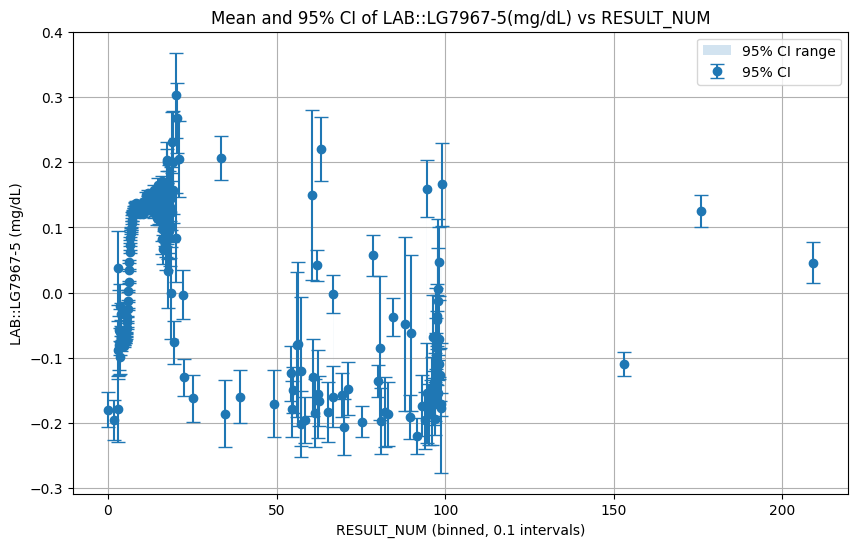

In [12]:
from scipy.stats import sem
# Define bins for RESULT_NUM intervals
lab_diabetesT2p['RESULT_NUM_bin'] = pd.cut(lab_diabetesT2p['RESULT_NUM'], 
                                           bins=np.arange(lab_diabetesT2p['RESULT_NUM'].min(), 
                                                          lab_diabetesT2p['RESULT_NUM'].max() + 0.1, 
                                                          0.1), 
                                           include_lowest=True)

# Group by the bins and calculate statistics
grouped = lab_diabetesT2p.groupby('RESULT_NUM_bin')['LAB::LG7967-5(mg/dL)_vals']
mean_vals = grouped.mean()
std_vals = grouped.std()
count_vals = grouped.count()
sem_vals = grouped.apply(sem)  # Standard Error of Mean
ci_95 = sem_vals * 1.96  # Approximation for 95% confidence interval

# Extract bin centers for plotting
bin_centers = [interval.mid for interval in mean_vals.index.categories]

# Plot the results
plt.figure(figsize=(10, 6))
plt.errorbar(bin_centers, mean_vals, yerr=ci_95, fmt='o', capsize=5, label='95% CI')
plt.fill_between(bin_centers, mean_vals - ci_95, mean_vals + ci_95, alpha=0.2, label='95% CI range')
plt.xlabel('RESULT_NUM (binned, 0.1 intervals)')
plt.ylabel('LAB::LG7967-5 (mg/dL)')
plt.title('Mean and 95% CI of LAB::LG7967-5(mg/dL) vs RESULT_NUM')
plt.legend()
plt.grid()
plt.show()

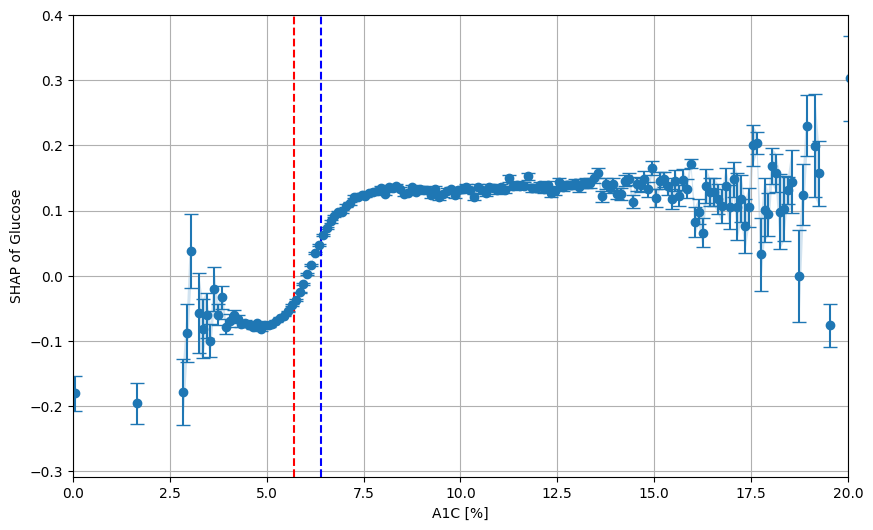

In [20]:
from scipy.stats import sem
# Define bins for RESULT_NUM intervals
lab_diabetesT2p['RESULT_NUM_bin'] = pd.cut(lab_diabetesT2p['RESULT_NUM'], 
                                           bins=np.arange(lab_diabetesT2p['RESULT_NUM'].min(), 
                                                          lab_diabetesT2p['RESULT_NUM'].max() + 0.1, 
                                                          0.1), 
                                           include_lowest=True)

# Group by the bins and calculate statistics
grouped = lab_diabetesT2p.groupby('RESULT_NUM_bin')['LAB::LG7967-5(mg/dL)_vals']
mean_vals = grouped.mean()
std_vals = grouped.std()
count_vals = grouped.count()
sem_vals = grouped.apply(sem)  # Standard Error of Mean
ci_95 = sem_vals * 1.96  # Approximation for 95% confidence interval

# Extract bin centers for plotting
bin_centers = [interval.mid for interval in mean_vals.index.categories]

# Plot the results
plt.figure(figsize=(10, 6))
plt.errorbar(bin_centers, mean_vals, yerr=ci_95, fmt='o', capsize=5, label='95% CI')
plt.fill_between(bin_centers, mean_vals - ci_95, mean_vals + ci_95, alpha=0.2, label='95% CI range23')
plt.xlabel('A1C [%]')
plt.ylabel('SHAP of Glucose')
#plt.legend()
plt.grid()
plt.xlim(0, 20) 
plt.axvline(x=5.7, color='red', linestyle='--', label='Threshold 5.7')
plt.axvline(x=6.4, color='blue', linestyle='--', label='Threshold 6.4')

plt.savefig(f"a1c.svg", bbox_inches='tight')
plt.show()



## 